# More Dataset Generation

This notebook is for expanding on [01_dataset_generation](/01_dataset_generation.ipynb), where we generated our initial dataset. After completing our first notebook we found more datasets that may be useful in developing our UHI model. Again, we may or may not add additional variables later in our pipeline

## Dataset Description

Please relate to our [first notebook](/01_dataset_generation.ipynb) to find a description on our other datasets. This notebook will only explain our new datasets we found.

### Feature Datasets:

- **Building Footprint Data with Additional Attributes**
   - Data from NYC Office of Technology and Innovation (OTI)
   - Useful for understanding the impact of buildings on local temperatures.
   - This dataset has more attributes than **Building Footprint Data** such as Building height.
   - link: https://data.cityofnewyork.us/City-Government/Building-Footprints/5zhs-2jue

- **Automated Traffic Volume Counts**
   -  Data from New York City Department of Transportation (NYC DOT)
   - Useful for understanding the impact of traffic on local temperatures.
   - link: https://data.cityofnewyork.us/Transportation/Automated-Traffic-Volume-Counts/7ym2-wayt

## Combining The Data

### Set Up

Download libraries not in google collab (can be disregarded if not using collab)

In [ ]:
%pip install stackstac
%pip install pystac-client
%pip install planetary-computer
%pip install odc-stac
%pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.0 MB/s eta 0:00:00


Import libraries

In [ ]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu
from google.colab import drive
import geopandas as gpd
from shapely.geometry import Point, Polygon
from rasterio.mask import mask
from shapely.ops import transform
import pyproj
import shapely.vectorized
from geopy.distance import geodesic
from shapely import wkt
import folium

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer
from odc.stac import stac_load

#other libs
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from datetime import timedelta
from IPython.display import HTML, display
from google.colab import userdata
from geopy.geocoders import GoogleV3
import os

Mount google drive, ignore if not using Google Collab:

In [ ]:
# mount google drive
drive.mount('/content/drive')
%cd /content/drive/My Drive
!git clone https://github.com/FranciscoLozCoding/cooling_with_code.git
%cd cooling_with_code
!git pull

Mounted at /content/drive
/content/drive/My Drive
fatal: destination path 'cooling_with_code' already exists and is not an empty directory.
/content/drive/My Drive/cooling_with_code
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 1.28 KiB | 0 bytes/s, done.
From https://github.com/FranciscoLozCoding/cooling_with_code
   1e14a9c..cf97504  main       -> origin/main
Updating 1e14a9c..cf97504
Fast-forward
 01_dataset_generation.ipynb | 132 ++++++++++++++++++++++++++++++++--------------------------------
 1 file changed, 66 insertions(+), 66 deletions(-)
fatal: cannot exec '.git/hooks/post-merge': Permission denied


### Helper Functions

In [ ]:
def geocode_intersection_google(row, api_key):
    """
    Geocode an intersection using the Google Maps Geocoding API.

    Parameters:
        row (pd.Series): A row from the traffic dataset.
        api_key (str): Your Google Maps Geocoding API key.

    Returns:
        pd.Series: A Series with 'lat' and 'lon' for the intersection.
    """
    geolocator = GoogleV3(api_key=api_key)

    # Construct the query string. Adjust the format as needed.
    if pd.notnull(row['fromSt']) and pd.notnull(row['street']):
        query = f"{row['street']} & {row['fromSt']}, {row['Boro']}, New York, NY"
    else:
        query = f"{row['street']}, {row['Boro']}, New York, NY"

    try:
        location = geolocator.geocode(query)
        if location:
            return pd.Series({'lat': location.latitude, 'lon': location.longitude})
    except Exception as e:
        print(f"Error geocoding query '{query}': {e}")

    return pd.Series({'lat': None, 'lon': None})

In [ ]:
def load_building_footprints_csv(csv_file):
    """
    Load building footprint polygons from a CSV file.

    Parameters:
        csv_file (str): Path to the CSV file containing building footprints with additional attributes.

    Returns:
        GeoDataFrame: A GeoDataFrame of building footprints in EPSG:4326.
    """
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Rename 'the_geom' to 'geometry'
    df = df.rename(columns={'the_geom': 'geometry'})

    # Convert the 'the_geom' column from WKT strings to Shapely geometries.
    df['geometry'] = df['geometry'].apply(wkt.loads)

    # Create a GeoDataFrame using the converted geometry
    buildings_gdf = gpd.GeoDataFrame(df, geometry='geometry')

    # Set the CRS to EPSG:4326
    buildings_gdf = buildings_gdf.set_crs(epsg=4326)

    return buildings_gdf

In [ ]:
def buildings_in_buffer(buffer_geom, buildings_gdf, epsg_code_for_meters="EPSG:32618"):
    """
    Calculate building density metrics within a buffer.

    Parameters:
        buffer_geom (shapely.geometry.Polygon): The buffer in EPSG:4326.
        buildings_gdf (GeoDataFrame): Building footprints in EPSG:4326.
        metric_epsg (int): EPSG code for a metric CRS (default is 32618 for New York).

    Returns:
        dict: Contains 'building_count', 'total_building_area' (m²), and 'density' (fraction of buffer area covered).
    """
    # Project both the buildings and buffer to a metric CRS.
    buildings_metric = buildings_gdf.to_crs(epsg_code_for_meters)
    buffer_metric = gpd.GeoSeries([buffer_geom], crs="EPSG:4326").to_crs(epsg_code_for_meters).iloc[0]

    # Compute the area of the buffer (in m²)
    buffer_area = buffer_metric.area

    # Select buildings that intersect the buffer.
    buildings_in_buffer = buildings_metric[buildings_metric.intersects(buffer_metric)]
    building_count = len(buildings_in_buffer)

    # For a more precise estimate, compute the intersection area of each building with the buffer.
    intersection_area = buildings_in_buffer.intersection(buffer_metric).area.sum()
    density = intersection_area / buffer_area if buffer_area > 0 else np.nan

    return {
        "building_count": building_count,
        "total_building_area_m2": intersection_area,
        "building_density": density
    }

In [ ]:
def average_band_in_buffer(buffer_geom, xarray, band_name, project_to_utm, project_to_wgs84):
    """
    Calculate the average values of a given band within a circular buffer.

    Parameters:
        buffer_geom (shapely.geometry.Polygon): The buffer in EPSG:4326.
        xarray (xarray.DataArray or xarray.Dataset): Xarray object containing the band.
            It must have 1D coordinate arrays 'latitude' and 'longitude' in EPSG:4326.
        band_name (str): Name of the band to process (e.g., 'NDVI').
        project_to_utm (pyproj.Transformer): Transformer to project points to UTM.
        project_to_wgs84 (pyproj.Transformer): Transformer to project points back to WGS84.

    Returns:
        float: The average band value within the buffer. Returns NaN if no grid cells are found.
    """

    # Extract coordinate arrays from the xarray data.
    # Assumes that the band is available in xarray[band_name]
    lons = xarray[band_name].coords['longitude'].values
    lats = xarray[band_name].coords['latitude'].values

    # Create a 2D meshgrid of longitude and latitude.
    lon_grid, lat_grid = np.meshgrid(lons, lats)

    # Create a boolean mask for grid cells that fall inside the buffer.
    mask = shapely.vectorized.contains(buffer_geom, lon_grid, lat_grid)

    # Extract the band values as a NumPy array.
    band_data = xarray[band_name].values

    # Compute the average of the band values inside the buffer.
    # np.nanmean ignores NaN values if they exist.
    if np.any(mask):
        average_val = np.nanmean(band_data[mask])
    else:
        average_val = np.nan

    return average_val

In [ ]:
def generate_buffer_dataset(latitudes, longitudes, buffer_radius, xarray, buildings_gdf, UHI=None, datetimes=None, epsg_code_for_meters="EPSG:32618"):
    '''
    Generate a dataset with averaged indices and building density metrics per buffer.

    Parameters:
        latitudes (list): Latitudes of center points (EPSG:4326).
        longitudes (list): Longitudes of center points (EPSG:4326).
        buffer_radius (float): Buffer radius in meters.
        xarray (xarray.DataArray or Dataset): Contains the indices (e.g., 'NDVI', 'NDBI', etc.).
        buildings_gdf (GeoDataFrame): Building footprints (loaded from a KML file), in EPSG:4326.
        UHI (list. optional): List of UHI values.
        datetimes (list, optional): Corresponding datetimes.
        epsg_code_for_meters (str, optional): EPSG code for metric projection (e.g., "EPSG:32618" for New York).

    Returns:
        DataFrame: A DataFrame with indices averaged per buffer plus building density metrics.
    '''
    # Set up CRS and transformation functions.
    crs_wgs84 = pyproj.CRS("EPSG:4326")
    crs_utm = pyproj.CRS(epsg_code_for_meters)

    # Create transformation functions.
    project_to_utm = pyproj.Transformer.from_crs(crs_wgs84, crs_utm, always_xy=True).transform
    project_to_wgs84 = pyproj.Transformer.from_crs(crs_utm, crs_wgs84, always_xy=True).transform

    # Helper function to process a single point.
    def process_point(lat, lon):
        # Create the buffer around the point.
        point = Point(lon, lat)
        point_utm = transform(project_to_utm, point)
        buffer_utm = point_utm.buffer(buffer_radius)
        buffer_wgs84 = transform(project_to_wgs84, buffer_utm)

        # Calculate spectral indices.
        ndvi_value  = average_band_in_buffer(buffer_wgs84, xarray, 'NDVI', project_to_utm, project_to_wgs84)
        ndbi_value  = average_band_in_buffer(buffer_wgs84, xarray, 'NDBI', project_to_utm, project_to_wgs84)
        ndwi_value  = average_band_in_buffer(buffer_wgs84, xarray, 'NDWI', project_to_utm, project_to_wgs84)
        si_value    = average_band_in_buffer(buffer_wgs84, xarray, 'SI', project_to_utm, project_to_wgs84)
        ndmi_value  = average_band_in_buffer(buffer_wgs84, xarray, 'NDMI', project_to_utm, project_to_wgs84)
        npcri_value = average_band_in_buffer(buffer_wgs84, xarray, 'NPCRI', project_to_utm, project_to_wgs84)
        ca_value    = average_band_in_buffer(buffer_wgs84, xarray, 'Coastal_Aerosol', project_to_utm, project_to_wgs84)

        # Calculate building density metrics using the same buffer.
        building_metrics = buildings_in_buffer(buffer_wgs84, buildings_gdf, epsg_code_for_meters)

        # Return all results.
        return (ndvi_value, ndbi_value, ndwi_value, si_value, ndmi_value, npcri_value, ca_value,
                building_metrics["building_count"], building_metrics["total_building_area_m2"], building_metrics["building_density"])

    # Process all points in parallel.
    results = Parallel(n_jobs=-1)(
        delayed(process_point)(lat, lon)
        for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Processing points")
    )

    # Unpack results.
    (ndvi_values, ndbi_values, ndwi_values, si_values,
     ndmi_values, npcri_values, ca_values,
     building_counts, building_areas, building_densities) = zip(*results)

    # Build the DataFrame.
    df = pd.DataFrame({
        'Longitude': longitudes,
        'Latitude': latitudes,
        'datetime': None if datetimes is None else pd.to_datetime(datetimes),
        'UHI': UHI,
        'NDVI': ndvi_values,
        'NDBI': ndbi_values,
        'NDWI': ndwi_values,
        'SI': si_values,
        'NDMI': ndmi_values,
        'NPCRI': npcri_values,
        'Coastal_Aerosol': ca_values,
        'Building_Count': building_counts,
        'Total_Building_Area_m2': building_areas,
        'Building_Density': building_densities
    })
    return df

In [ ]:
# Function to determine the nearest weather station (Bronx or Manhattan)
def assign_weather_station(lat, lon):
    '''
    Assign a county (Bronx or Manhattan) based on the closest weather station.

      Parameters:
        lat (float): Latitude of the point (EPSG:4326).
        lon (float): Longitude of the point (EPSG:4326).

      Returns:
        str: 'Bronx' or 'Manhattan' based on the closest weather station.
    '''
    # Define the coordinates for Bronx and Manhattan
    bronx_coords = (40.87248, -73.89352)  # Bronx: (Latitude, Longitude)
    manhattan_coords = (40.76754, -73.96449)  # Manhattan: (Latitude, Longitude)

    # Calculate distance to Bronx and Manhattan using geopy's geodesic function
    distance_bronx = geodesic((lat, lon), bronx_coords).meters
    distance_manhattan = geodesic((lat, lon), manhattan_coords).meters

    # Assign the county based on the shortest distance
    if distance_bronx < distance_manhattan:
        return 'Bronx'
    else:
        return 'Manhattan'

In [ ]:
# Function to find the closest datetime in the weather data
def find_closest_datetime(row, weather_data):
    '''
    Find the closest datetime in the weather data to the given row's datetime.

    Parameters:
        row (pd.Series): A row from a DataFrame containing a 'datetime' column.
        weather_data (pd.DataFrame): A DataFrame containing the weather data with a 'Date / Time' column.

    Returns:
        pd.Series: The row from weather_data with the closest datetime.
    '''
    # Calculate the absolute time difference between the row's datetime and each weather datetime
    time_diff = abs(weather_data['Date / Time'] - row['datetime'])

    # Find the index of the minimum time difference (closest datetime)
    closest_idx = time_diff.idxmin()

    # Return the row with the closest datetime
    return weather_data.iloc[closest_idx]

In [ ]:
# Function to assign weather data based on county and closest datetime
def assign_weather_data(row, weather_manhattan, weather_bronx):
    '''
      Assign weather data based on the county and closest datetime.

      Parameters:
        row (pd.Series): A row from a DataFrame containing 'Latitude' and 'Longitude' columns.
        weather_manhattan (pd.DataFrame): A DataFrame containing weather data for Manhattan.
        weather_bronx (pd.DataFrame): A DataFrame containing weather data for Bronx.

      Returns:
        pd.Series: A row with the closest weather data
    '''
    # Determine which county the row belongs to
    county = assign_weather_station(row['Latitude'], row['Longitude'])

    # Find the closest weather data based on county
    if county == 'Manhattan':
        closest_weather = find_closest_datetime(row, weather_manhattan)
    elif county == 'Bronx':
        closest_weather = find_closest_datetime(row, weather_bronx)
    else:
        # Handle the case where the county is not recognized
        raise ValueError(f"Unknown county: {county}")

    # Return the weather data to merge
    return pd.Series({
        'Air Temp at Surface [degC]': closest_weather['Air Temp at Surface [degC]'],
        'Relative Humidity [percent]': closest_weather['Relative Humidity [percent]'],
        'Avg Wind Speed [m/s]': closest_weather['Avg Wind Speed [m/s]'],
        'Wind Direction [degrees]': closest_weather['Wind Direction [degrees]'],
        'Solar Flux [W/m^2]': closest_weather['Solar Flux [W/m^2]']
    })

In [ ]:
def assign_weather_data_avg(row, weather_manhattan, weather_bronx):
    '''
    Assign weather data based on the county and average the values
    from 3:00 pm to 4:00 pm on July 24, 2021.

    Parameters:
      row (pd.Series): A row from a DataFrame containing at least a 'Latitude' and 'Longitude' column.
      weather_manhattan (pd.DataFrame): Weather data for Manhattan, including a 'datetime' column.
      weather_bronx (pd.DataFrame): Weather data for Bronx, including a 'datetime' column.

    Returns:
      pd.Series: A series with the averaged weather data for the specified time period.
    '''
    import pandas as pd

    # Determine which county the row belongs to (assumes you have this helper function)
    county = assign_weather_station(row['Latitude'], row['Longitude'])

    # Select the appropriate weather dataset
    if county == 'Manhattan':
        weather = weather_manhattan
    elif county == 'Bronx':
        weather = weather_bronx
    else:
        raise ValueError(f"Unknown county: {county}")

    # Define the time window: 3:00 pm to 4:00 pm on July 24, 2021
    start_time = pd.Timestamp('2021-07-24 15:00:00')
    end_time = pd.Timestamp('2021-07-24 16:00:00')

    # Filter weather data for this time period
    time_mask = (weather['Date / Time'] >= start_time) & (weather['Date / Time'] <= end_time)
    weather_window = weather.loc[time_mask]

    # Compute the average of the selected weather parameters
    # (Make sure the weather DataFrame has the columns exactly as specified.)
    weather_avg = weather_window.mean()

    # Return the averaged weather values as a Series.
    return pd.Series({
        'Air Temp at Surface [degC]': weather_avg['Air Temp at Surface [degC]'],
        'Relative Humidity [percent]': weather_avg['Relative Humidity [percent]'],
        'Avg Wind Speed [m/s]': weather_avg['Avg Wind Speed [m/s]'],
        'Wind Direction [degrees]': weather_avg['Wind Direction [degrees]'],
        'Solar Flux [W/m^2]': weather_avg['Solar Flux [W/m^2]']
    })

### Reused Code

We will need code we used in our first notebook, to be able to analyze our new datasets.

>NOTE: code that is reused from [01_dataset_generation](/01_dataset_generation.ipynb) will not be explained here, refer to [01_dataset_generation](/01_dataset_generation.ipynb) for a more in depth explanation.

In [ ]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [ ]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [ ]:
# Define the time window
time_window = "2021-06-01/2021-09-01"

In [ ]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 20}},
)

In [ ]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 7


In [ ]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 5  # meters per pixel
scale = resolution / 111320.0 # degrees per pixel for crs=4326

In [ ]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [ ]:
median = data.median(dim="time").compute()

In [ ]:
# Calculate NDVI for the median composite
ndvi_median = (median.B08-median.B04)/(median.B08+median.B04)

# Calculate NDBI for the median composite
ndbi_median = (median.B11-median.B08)/(median.B11+median.B08)

# Calculate NDWI for the median composite
ndwi_median = (median.B03-median.B08)/(median.B03+median.B08)

# Calculate SI for the median composite
si_median = (median.B11 - median.B04)/(median.B11 + median.B04)

# Calculate NDMI for the median composite
ndmi_median = (median.B08 - median.B11)/(median.B08 + median.B11)

# Calculate NPCRI for the median composite
npcri_median = (median.B04 - median.B02) / (median.B04 + median.B02)

In [ ]:
# Add indices to the dataset
median['NDVI'] = (['latitude', 'longitude'], ndvi_median.values)
median['NDBI'] = (['latitude', 'longitude'], ndbi_median.values)
median['NDWI'] = (['latitude', 'longitude'], ndwi_median.values)
median['SI'] = (['latitude', 'longitude'], si_median.values)
median['NDMI'] = (['latitude', 'longitude'], ndmi_median.values)
median['NPCRI'] = (['latitude', 'longitude'], npcri_median.values)
median['Coastal_Aerosol'] = (['latitude', 'longitude'], median.B01.values)

Now, we are able to analyze our new datasets. First we will start with our building footprint dataset that contains additional attributes.

### Building Footprint Data with Additional Attributes

This new building footprint dataset differs from the previous one by including additional attributes, such as **building height**, and it is in a **CSV format**. Building height is important for predicting the **Urban Heat Island (UHI)** effect due to the [**Urban Canyon Effect**](https://medium.com/the-machinery-of-government/canyon-effect-in-australian-cities-ce496190c760). This phenomenon occurs when tall buildings line city streets, creating canyon-like environments that block wind and trap heat, increasing UHI. We will use this new dataset in the same way as the previous one, but with additional metrics like the **average building height** within a [**Buffer Zone**](https://atlas.co/glossary/buffer-zones/). By averaging building heights around each data point, we can assess the potential for the **Urban Canyon Effect**, where higher buildings trap heat and affect local temperatures, contributing to increased UHI.

The variable descriptions are [here](https://data.cityofnewyork.us/City-Government/Building-Footprints/5zhs-2jue/about_data).

In [ ]:
# Load the Building Footprints
building_csv_file = "data/Building_Footprints_With_Add_Attr.csv"
buildings_gdf = load_building_footprints_csv(building_csv_file)

In [ ]:
buildings_gdf.head(3)

,geometry,NAME,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,BASE_BBL,MPLUTO_BBL,GEOMSOURCE,GLOBALID
0,"MULTIPOLYGON (((-73.96665 40.626, -73.96685 40...",NaN,3170958,1925.0,08/22/2017,Constructed,96807,29.749853,2100,40.0,0,0,3065220021,3065220021,Photogramm,{31298F86-3088-4F53-B3DB-71A9EFA6FA1F}
1,"MULTIPOLYGON (((-74.1679 40.63936, -74.1679 40...",NaN,5028452,1965.0,08/22/2017,Constructed,326368,22.630000,2100,39.0,0,0,5012640036,5012640036,Photogramm,{F5F8CDA5-69E2-46F8-8F69-BA95C025B520}
2,"MULTIPOLYGON (((-74.19511 40.55611, -74.1952 4...",NaN,5078368,1970.0,08/22/2017,Constructed,746627,35.760000,2100,51.0,0,0,5060190091,5060190091,Photogramm,{9F644794-F72C-4582-9E5E-B337E2B97068}


In [ ]:
buildings_gdf.describe()

,BIN,CNSTRCT_YR,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,BASE_BBL,MPLUTO_BBL
count,1.082823e+06,1.072604e+06,1.082823e+06,1.082823e+06,1.082823e+06,1.082275e+06,1082823.0,1082823.0,1.082823e+06,1.082823e+06
mean,3.713303e+06,1.939701e+03,5.953790e+05,2.775390e+01,2.693235e+03,5.512690e+01,0.0,0.0,3.564393e+09,3.564393e+09
std,1.026560e+06,2.955052e+01,3.625806e+05,2.215586e+01,1.198303e+03,4.154864e+01,0.0,0.0,9.857466e+08,9.857465e+08
min,1.000000e+06,1.652000e+03,1.000000e+00,0.000000e+00,1.000000e+03,-1.600000e+01,0.0,0.0,1.000010e+09,1.000010e+09
25%,3.129874e+06,1.920000e+03,2.882855e+05,1.853000e+01,2.100000e+03,2.500000e+01,0.0,0.0,3.043480e+09,3.043480e+09
50%,4.068018e+06,1.930000e+03,5.767610e+05,2.614000e+01,2.100000e+03,4.600000e+01,0.0,0.0,4.019590e+09,4.019590e+09
75%,4.483622e+06,1.955000e+03,8.670855e+05,3.116000e+01,2.100000e+03,7.400000e+01,0.0,0.0,4.107020e+09,4.107020e+09
max,5.799523e+06,2.025000e+03,1.303117e+06,1.550000e+03,5.110000e+03,1.335000e+03,0.0,0.0,6.000000e+09,6.000000e+09


We can see the building footprints by using NYC Open Data, we did not build our own map since the dataset is way too big it will take forever. We see here that this dataset has buildings that we don't need. We are only interested in Manhattan and Bronx, so we will need to filter the dataset to only the buildings we need.

In [ ]:
iframe_code = """
  <iframe
    allow="geolocation" src="https://data.cityofnewyork.us/dataset/Building-Footprints-Map-/3g6p-4u5s/embed?width=800&height=600"
    width="800" height="600" style="border:0; padding: 0; margin: 0;">
  </iframe>
  """
display(HTML(iframe_code))

To filter the dataset we will check which buildings fall into the bounding box we are using for New York City. We will also apply padding to shrink the bounding box, ensuring buildings on the edge are excluded.

In [ ]:
padding = 0.0015

# Compute the centroid for each building polygon.
# Then filter the bldg GeoDataFrame based on the bounding box we are using for New York City
buildings_gdf = buildings_gdf[
    (buildings_gdf.geometry.centroid.y >= lower_left[0] + padding) &
    (buildings_gdf.geometry.centroid.y <= upper_right[0] - padding) &
    (buildings_gdf.geometry.centroid.x >= lower_left[1] + padding) &
    (buildings_gdf.geometry.centroid.x <= upper_right[1] - padding)
]

Now, we can see the filtered building footprints by plotting it against a satellite image of New York.

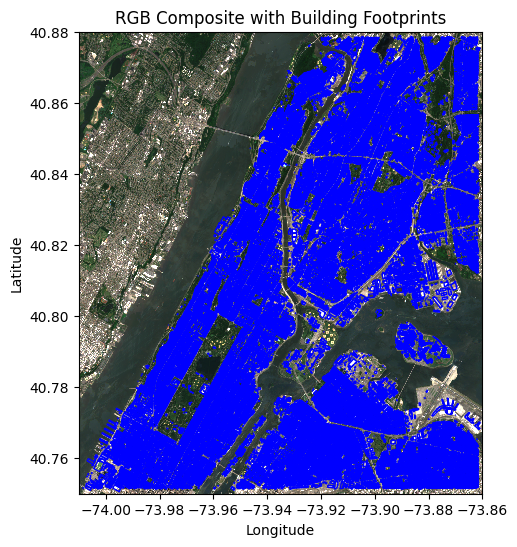

In [ ]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(7, 6))

# Plot the RGB composite from the median composite.
# This will serve as the base layer.
median[["B04", "B03", "B02"]].to_array().plot.imshow( ax=ax, robust=True, vmin=0, vmax=2500)

# Overlay the building footprints on the same axis.
# building footprints are in EPSG:4326 (lon,lat) so we can plot them directly.
buildings_gdf.plot( ax=ax, edgecolor='blue', facecolor='none')

# Add labels and title.
ax.set_title("RGB Composite with Building Footprints")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

Before we move on, we will remove any variables that are not needed.

In [ ]:
#drop cols we dont need
buildings_gdf.drop(columns=["NAME","BIN",
                            "LSTMODDATE", "LSTSTATYPE", "DOITT_ID",
                            "FEAT_CODE", "SHAPE_AREA", "SHAPE_LEN",
                            "BASE_BBL", "MPLUTO_BBL", "GEOMSOURCE",
                            "GLOBALID"],inplace=True)
buildings_gdf

,geometry,CNSTRCT_YR,HEIGHTROOF,GROUNDELEV
18,"MULTIPOLYGON (((-73.9387 40.83782, -73.93863 4...",1910.0,59.722628,154.0
28,"MULTIPOLYGON (((-73.89129 40.75272, -73.89117 ...",1950.0,27.490000,46.0
48,"MULTIPOLYGON (((-73.87287 40.80269, -73.8729 4...",1973.0,10.546547,11.0
68,"MULTIPOLYGON (((-73.96425 40.7586, -73.96421 4...",1931.0,167.214468,52.0
86,"MULTIPOLYGON (((-73.99058 40.76523, -73.99065 ...",1910.0,28.570000,40.0
...,...,...,...,...
1082156,"MULTIPOLYGON (((-73.94633 40.79713, -73.94644 ...",2023.0,408.800000,17.0
1082179,"MULTIPOLYGON (((-73.86802 40.75266, -73.86793 ...",2023.0,36.000000,64.0
1082453,"MULTIPOLYGON (((-73.94734 40.80141, -73.94736 ...",2016.0,125.000000,22.0
1082548,"MULTIPOLYGON (((-73.98235 40.76489, -73.98235 ...",NaN,645.000000,75.0


>NOTE: we don't need to normalize HEIGHTROOF (building height) based on ground level. Data host already did that. This is their description of the column "The height of the roof above the ground elevation, not height above sea level."

Now, as we did in our old building dataset, we will use Buffer Zones to compute building metrics.

In [ ]:
# Example point
lat_pt = 40.85880833
lon_pt = -73.932645

# Create a Shapely point
point = Point(lon_pt, lat_pt)

# Define coordinate reference systems (CRS)
crs_wgs84 = pyproj.CRS("EPSG:4326")   # original CRS (degrees)
crs_utm18 = pyproj.CRS("EPSG:32618")    # UTM zone 18N (meters)

# Create transformers to project back and forth
project_to_utm = pyproj.Transformer.from_crs(crs_wgs84, crs_utm18, always_xy=True).transform
project_to_wgs84 = pyproj.Transformer.from_crs(crs_utm18, crs_wgs84, always_xy=True).transform

# Project the point to UTM and create a buffer
point_utm = transform(project_to_utm, point)
buffer_radius = 150 # radius in meters (diameter will be 300)
buffer_utm = point_utm.buffer(buffer_radius)

# Transform the buffer back to WGS84
buffer_wgs84 = transform(project_to_wgs84, buffer_utm)

# The coordinates are one-dimensional arrays for latitude and longitude.
lons = median['NDVI'].coords['longitude'].values
lats = median['NDVI'].coords['latitude'].values

# Create a meshgrid so that each grid cell has a lon/lat pair.
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Use Shapely’s vectorized function to test which grid points fall inside the buffer.
mask = shapely.vectorized.contains(buffer_wgs84, lon_grid, lat_grid)
# 'mask' is a boolean array (True for points inside the buffer)

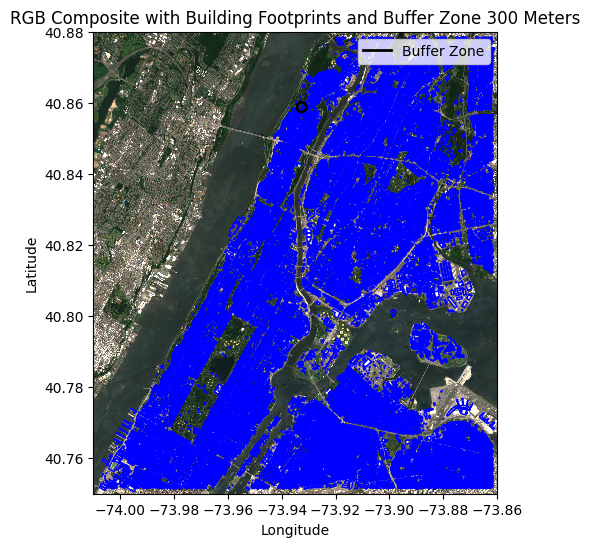

In [ ]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(7, 6))

# Plot the RGB composite from the median composite.
# This will serve as the base layer.
median[["B04", "B03", "B02"]].to_array().plot.imshow( ax=ax, robust=True, vmin=0, vmax=2500)

# Overlay the building footprints on the same axis.
# building footprints are in EPSG:4326 (lon,lat) so we can plot them directly.
buildings_gdf.plot( ax=ax, edgecolor='blue', facecolor='none')

# Plot the buffer polygon.
# Extract the exterior coordinates of the polygon.
x_buffer, y_buffer = buffer_wgs84.exterior.xy
ax.plot(x_buffer, y_buffer, color='black', linewidth=2, label='Buffer Zone')

# Add labels and title.
ax.set_title("RGB Composite with Building Footprints and Buffer Zone 300 Meters")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.show()

From this plot you can see we can calculate building density metrics in a buffer zone. We will do this in a later section. First, we need to load in our next new dataset: **Automated Traffic Volume Counts**

### Automated Traffic Volume Counts

This new dataset includes traffic sample volume counts at bridge crossings and roadways. This will help us predict UHI since traffic increases [Anthropogenic heat](https://www.sciencedirect.com/topics/engineering/anthropogenic-heat#:~:text=1.4%20Anthropogenic%20Heat-,Anthropogenic%20heat%20represents%20%E2%80%9Chuman%2Dmade%E2%80%9D%20heat%20generated%20by%20buildings,terms%20in%20the%20balance%20equation.). In cities, people drive cars in close contact with each other. When these heat-generating activities are concentrated over small areas, they can have significant impacts on the microclimate.

In [ ]:
# Load the traffic dataset
traffic_csv_file = "data/Automated_Traffic_Volume_Counts.csv"
traffic_df = pd.read_csv(traffic_csv_file)

# Combine the columns and create a new datetime string column
traffic_df['datetime_str'] = (
    traffic_df['Yr'].astype(str) + '-' +
    traffic_df['M'].astype(str).str.zfill(2) + '-' +
    traffic_df['D'].astype(str).str.zfill(2) + ' ' +
    traffic_df['HH'].astype(str).str.zfill(2) + ':' +
    traffic_df['MM'].astype(str).str.zfill(2) + ':00'
)

# Convert the datetime string column to a pandas datetime object
traffic_df['datetime'] = pd.to_datetime(traffic_df['datetime_str'], format='%Y-%m-%d %H:%M:%S')

#drop cols we don't need
traffic_df.drop(columns=["SegmentID", "RequestID",
                         "WktGeom", "Direction", "toSt",
                         'Yr', 'M', 'D', 'HH', 'MM',
                         'datetime_str'], inplace=True)

>NOTE: We are not using `WktGeom` (represents a vector geometry objects on a map) because the dataset does not state in what spatial system it is in.



In [ ]:
traffic_df.head(3)

,Boro,Vol,street,fromSt,datetime
0,Queens,0,PULASKI BRIDGE,Newtown Creek Shoreline,2021-04-30 02:00:00
1,Queens,1,PULASKI BRIDGE,Newtown Creek Shoreline,2021-04-30 02:15:00
2,Brooklyn,33,61 ST,15 AV,2012-12-18 08:15:00


Our target variable (UHI) was collected on Saturday July 24 2021 between 3:00 pm and 4:00 pm in Manhattan and Bronx, so we only need data points in that range. Although, the dataset does not include any data points on this day so we will take the average to capture which intersections have the highest traffic volumne.

In [ ]:
# Filter the GeoDataFrame to keep only the rows in boros
boros = ['Bronx', 'Manhattan']
filtered_df = traffic_df[traffic_df['Boro'].isin(boros)]

# Now group the filtered data by 'Boro', 'street', and 'fromSt'
# and calculate the average volume for each group.
grouped_traffic_df = (
    filtered_df.groupby(['Boro', 'street', 'fromSt'])['Vol']
               .mean()
               .reset_index(name='avg_vol')
)

In [ ]:
grouped_traffic_df.head(3)

,Boro,street,fromSt,avg_vol
0,Bronx,145 STREET BRIDGE APPROACH,145 Street Bridge,149.104167
1,Bronx,2ND EXIT FROM MALL TO BAYCHESTER AVE,BAYCHESTER AVENUE,2.305583
2,Bronx,3 AV,E 148 ST,121.459689


To get the latitude and longitude of each row we will use google's api to geo encode the intersections. Then we will convert the dataset into GeoDataFrame so it can work with our Buffer Zones.

>Note: to not call the api everytime, we will save and reuse already calculated points.

In [ ]:
key = userdata.get('GOOGLE_GEO_API_KEY')

#check if file was created already:
if os.path.isfile('grouped_traffic.csv'):
    grouped_traffic_df = pd.read_csv('grouped_traffic.csv')
    traffic_gdf = gpd.GeoDataFrame(grouped_traffic_df, geometry='geometry', crs='EPSG:4326')
else:
  # Apply the geocoding function to every row of the DataFrame
  grouped_traffic_df[['lat', 'lon']] = grouped_traffic_df.apply(lambda row: geocode_intersection_google(row, key), axis=1)

  # convert the lat/lon values to a geometry column.
  grouped_traffic_df['geometry'] = grouped_traffic_df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

  # Convert the DataFrame into a GeoDataFrame.
  traffic_gdf = gpd.GeoDataFrame(grouped_traffic_df, geometry='geometry', crs='EPSG:4326')

  # Save to csv file
  grouped_traffic_df.to_csv("grouped_traffic.csv", index=False)

Again, We will filter the dataset based on points that fall into the bounding box we are using for New York City.

In [ ]:
# filter the traffic GeoDataFrame based on the bounding box we are using for New York City
traffic_gdf = traffic_gdf[
    (traffic_gdf.geometry.y >= lower_left[0] + padding) &
    (traffic_gdf.geometry.y <= upper_right[0] - padding) &
    (traffic_gdf.geometry.x >= lower_left[1] + padding) &
    (traffic_gdf.geometry.x <= upper_right[1] - padding)
]

Now, we can see the filtered values by plotting it against a satellite image of New York.

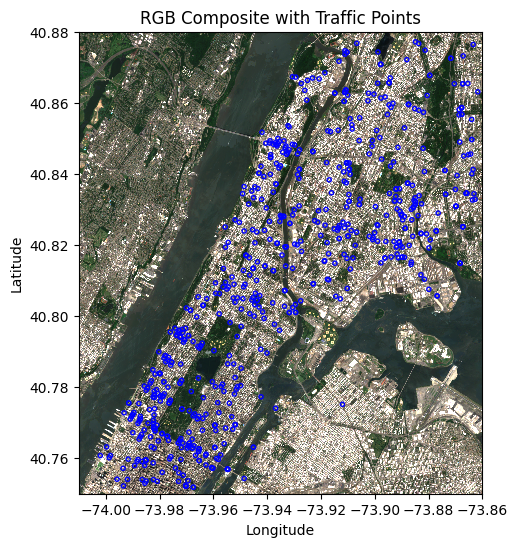

In [ ]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(7, 6))

# Plot the RGB composite from the median composite.
# This will serve as the base layer.
median[["B04", "B03", "B02"]].to_array().plot.imshow( ax=ax, robust=True, vmin=0, vmax=2500)

# Overlay the traffic points on the same axis.
# traffic points are in EPSG:4326 (lon,lat) so we can plot them directly.
traffic_gdf.plot( ax=ax, edgecolor='blue', facecolor='none', marker='.')

# Add labels and title.
ax.set_title("RGB Composite with Traffic Points")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

From this plot you can see we can calculate traffic volumes in a buffer zone. We will do this in the next section.

TODO: plot the UHI values with the traffic volumes to see if the traffic volumes reach the buffer zones